# MODEL GRIDS WITH PYCLOUDY

## Global budget

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc
pc.config.cloudy_exe = 'cloudy.exe'
models_dir = '/DATA/NEBULATOM17'

### Construct a series of plane-parallel models of density n = 100 cm$^{-3}$ ionized by a blackbody at 50,000 K, varying log U between -3.5 and -1.5 by steps of 0.5 dex and the metallicity as 12 + log O/H from 7 to 9 by steps of 0.5 dex (take He/H =0.1 for all the models and adopt the solar abundance ratios from Asplund et al. (2009) for all the heavy elements).

##### We define some function to prepare and run the grid of Cloudy models.

In [2]:
options = ('no molecules',
           'no level2 lines',
           'no fine opacities',
           'atom h-like levels small',
           'atom he-like levels small',
           'element limit off -7',
            )
from pyCloudy.utils.physics import abund_Asplund_2009

def get_R_in_Q0(logU, fr, NH=100, ff=1.0):
    c = pc.CST.CLIGHT
    U_mean = 10**logU
    w = (1 + fr**3.)**(1./3) - fr
    alpha_B = 2.6e-13
    Q0 = 4. * np.pi * c**3 * U_mean**3 / (3. * NH * ff**2 * alpha_B**2 * w**3)
    R_str = (3. * Q0 / (4 * np.pi * NH**2 * alpha_B * ff))**(1./3)
    R_in = fr * R_str
    return R_in, Q0

def make_mod(name, logU, ab_O):
    NH = 100
    ff = 0.1
    fr = 10.00
    R_in, Q0 = get_R_in_Q0(logU, fr=fr, NH=NH, ff=ff)
    c_input = pc.CloudyInput('{0}/{1}'.format(models_dir, name))
    c_input.set_BB(Teff = 50000., lumi_unit = 'q(H)', lumi_value = np.log10(Q0))
    c_input.set_cste_density(np.log10(NH), ff = ff)
    c_input.set_radius(r_in = np.log10(R_in))
    abund = abund_Asplund_2009.copy()
    delta_O = ab_O - 12 - abund['O']
    for elem in abund:
        if elem != 'He':
            abund[elem] += delta_O
    c_input.set_abund(ab_dict = abund)
    c_input.set_grains('Orion {}'.format(10**delta_O))
    c_input.set_distance(dist=1., unit='kpc', linear=True)
    c_input.set_other(options)
    c_input.set_stop(('temperature off', 'pfrac 0.02'))
    c_input.print_input()

In [3]:
generic_name = 'M7_'

##### We prepare the models

In [4]:
for logU in np.arange(-3.5, -1.49, 0.5):
    for ab_O in np.arange(7, 9.1, 0.5):
        name = '{}{:.1f}_{:.1f}'.format(generic_name, logU, ab_O)
        make_mod(name, logU, ab_O)

##### We run the models.

In [6]:
pc.run_cloudy(dir_=models_dir, n_proc=8, model_name=generic_name)

##### We read the models in a list.

In [5]:
Ms = pc.load_models('{}/{}'.format(models_dir, generic_name),
                    read_emis = False)

##### We verify that the Hbeta flux is available from the CloudyModel object.

In [7]:
print(np.float(pc.sextract(Ms[0].out['Hbeta'], 'H  1      4861.36A', '1.000').strip()))

41.794


##### We define the variables to be plotted. They are mainly obtained by looping on the models, using list comprehension technic.

In [8]:
x = np.array([M.log_U_mean for M in Ms])
logHb = np.array([np.float(pc.sextract(M.out['Hbeta'], 'H  1      4861.36A', '1.000').strip()) for M in Ms])
logQ = np.log10(np.array([M.Q.sum() for M in Ms]))
y = logHb - logQ
c = 12+np.array([M.abund['O'] for M in Ms])

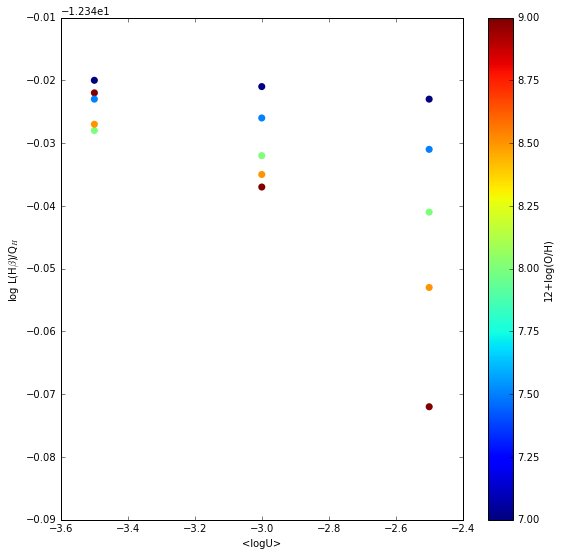

In [9]:
f, ax = plt.subplots(figsize=(9, 9))
sc = ax.scatter(x, y, c=c, edgecolor='none', s=50)
ax.set_xlabel('<logU>')
ax.set_ylabel(r'log L(H$\beta$)/Q$_ H$')
cb = f.colorbar(sc)
cb.set_label(r'12+log(O/H)')

In [10]:
# the following is to have the nice style in the Notebook.
# Don't remove this.
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()